# 00. 라이브러리 로드

In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow_datasets as tfds
import tensorflow as tf

# 01. Transformer 구조 함수 정의

### Transformer  
├── **Input Processing**  
│   ├── Positional Encoding Layer  
│   ├── Padding Mask  
│   └── Look-ahead Mask  
├── **Attention Mechanism**  
│   ├── Scaled Dot Product Attention  
│   └── Multi-Head Attention  
├── **Encoder**  
│   ├── Encoder Layer  
│   │   ├── Multi-Head Attention (Self-Attention)  
│   │   ├── Feed Forward Network  
│   │   └── Add & Norm (Residual + Layer Normalization)  
│   └── Stacking Encoder Layers  
├── **Decoder**  
│   ├── Decoder Layer  
│   │   ├── Masked Multi-Head Attention (Self-Attention)  
│   │   ├── Encoder-Decoder Attention  
│   │   ├── Feed Forward Network  
│   │   └── Add & Norm (Residual + Layer Normalization)  
│   └── Stacking Decoder Layers  
└── **Output Layer**  
    └── Final Linear Layer + Softmax  

## Input Processing

In [354]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Padding Mask 구현
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# Look-ahead Mask 구현
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

## Attention Mechanism

In [355]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [356]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## Encoder

In [357]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [358]:
# Encoder layer * N개 쌓기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder

In [359]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [360]:
# Decoder layer * N개 쌓기
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 02. 데이터 불러오기

In [361]:
## 파일 로드
chat_path = "~/aiffel/transformer_chatbot/data/ChatbotData .csv"
data = pd.read_csv(chat_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [362]:
# 샘플 개수와 null 값 확인
print('챗봇 샘플의 개수 :', len(data),'\n')
print('Null 값 확인\n',data.isnull().sum())

챗봇 샘플의 개수 : 11823 

Null 값 확인
 Q        0
A        0
label    0
dtype: int64


# 03. 데이터 전처리

In [363]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence 양쪽 공백을 제거
    sentence = sentence.strip()
    # 단어와 구두점 사이의 거리 생성
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 공백을 하나의 공백으로 변환
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, 숫자, 구두점(?, ., !, ,)을 제외한 모든 문자를 공백으로 대체
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9?.!,]", " ", sentence)
    # 양쪽 공백을 제거하고 최종 결과 반환
    sentence = sentence.strip()

    return sentence

In [364]:
# 전처리 적용 및 Q, A 분리
questions =[]
answers=[]
for idx, row in data.iterrows():
    questions.append(preprocess_sentence(row['Q']))
    answers.append(preprocess_sentence(row['A']))

In [365]:
# 질문과 답변 데이터 셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

INFO:absl:SubwordTextEncoder build: trying min_token_count 6695
INFO:absl:SubwordTextEncoder build: trying min_token_count 3347
INFO:absl:SubwordTextEncoder build: trying min_token_count 1673
INFO:absl:SubwordTextEncoder build: trying min_token_count 836
INFO:absl:SubwordTextEncoder build: trying min_token_count 418
INFO:absl:SubwordTextEncoder build: trying min_token_count 209
INFO:absl:SubwordTextEncoder build: trying min_token_count 104
INFO:absl:SubwordTextEncoder build: trying min_token_count 52
INFO:absl:SubwordTextEncoder build: trying min_token_count 26
INFO:absl:SubwordTextEncoder build: trying min_token_count 13
INFO:absl:SubwordTextEncoder build: trying min_token_count 6
INFO:absl:SubwordTextEncoder build: trying min_token_count 3
INFO:absl:SubwordTextEncoder build: trying min_token_count 4


In [366]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8161]
종료 토큰 번호 : [8162]
단어 집합의 크기 : 8163


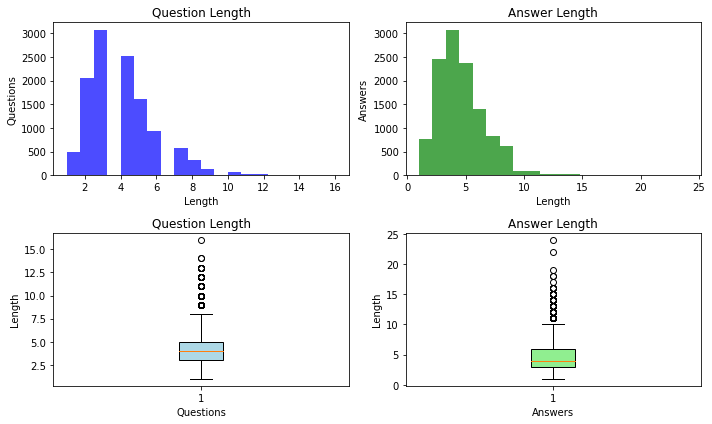

In [367]:
import matplotlib.pyplot as plt

# 각 문장의 길이를 계산하는 함수
def calculate_sentence_length(sentences):
    return [len(sentence.split()) for sentence in sentences]

# 질문과 답변의 길이 계산
question_lengths = calculate_sentence_length(questions)
answer_lengths = calculate_sentence_length(answers)

# 길이 시각화
plt.figure(figsize=(10, 6))

# 질문 길이 분포 히스토그램
plt.subplot(2, 2, 1)
plt.hist(question_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Question Length')
plt.xlabel('Length')
plt.ylabel('Questions')

# 답변 길이 분포 히스토그램
plt.subplot(2, 2, 2)
plt.hist(answer_lengths, bins=20, color='green', alpha=0.7)
plt.title('Answer Length')
plt.xlabel('Length')
plt.ylabel('Answers')

# 질문 길이 박스플롯
plt.subplot(2, 2, 3)
plt.boxplot(question_lengths, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Question Length')
plt.xlabel('Questions')
plt.ylabel('Length')

# 답변 길이 박스플롯
plt.subplot(2, 2, 4)
plt.boxplot(answer_lengths, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Answer Length')
plt.xlabel('Answers')
plt.ylabel('Length')

plt.tight_layout()
plt.show()

In [368]:
# 패딩을 진행하고자 정의 -> 마스킹이 진행되므로 우선은 데이터의 가장 이상치인 30로 설정
MAX_LENGTH = 15

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩 함수화
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    
    # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

  # 패딩 -> post로 적용
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [369]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

단어장의 크기 : 8163
질문 데이터의 크기(shape) : (11570, 15)
답변 데이터의 크기(shape) : (11570, 15)


In [370]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 05. Transformer 모델 생성

In [371]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [372]:
# 하이퍼 파라미터 조정을 통한 모델 정의

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4198144     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [373]:
# Loss fuction -> 시퀀스에 패딩이 되어 있으므로 패딩 적용
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [374]:
# custom learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [375]:
# 학습률과 옵티마이저를 정의하고 모델 컴파일

learning_rate = CustomSchedule(D_MODEL)


optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 05. Transformer 모델 학습

In [376]:
# 모델 학습
EPOCHS = 80

history = model.fit(
    dataset,
    epochs=EPOCHS
)

Epoch 1/80
181/181 [==============================] - 20s 52ms/step - loss: 3.9424 - accuracy: 0.0582
Epoch 2/80
181/181 [==============================] - 9s 51ms/step - loss: 3.2321 - accuracy: 0.1170
Epoch 3/80
181/181 [==============================] - 9s 52ms/step - loss: 2.7633 - accuracy: 0.1392
Epoch 4/80
181/181 [==============================] - 9s 51ms/step - loss: 2.5818 - accuracy: 0.1448
Epoch 5/80
181/181 [==============================] - 9s 52ms/step - loss: 2.4739 - accuracy: 0.1511
Epoch 6/80
181/181 [==============================] - 9s 52ms/step - loss: 2.3810 - accuracy: 0.1561
Epoch 7/80
181/181 [==============================] - 9s 51ms/step - loss: 2.2863 - accuracy: 0.1608
Epoch 8/80
181/181 [==============================] - 9s 52ms/step - loss: 2.1806 - accuracy: 0.1669
Epoch 9/80
181/181 [==============================] - 10s 53ms/step - loss: 2.0579 - accuracy: 0.1762
Epoch 10/80
181/181 [==============================] - 9s 52ms/step - loss: 1.9248 - accu

# 06. 모델 평가하기 - 정성적 평가

In [377]:
# 트랜스 포머 모델에 전처리가 진행된 사용자의 입력을 전달하여 단어 예측 수행
def evaluate(sentence):
  # 입력 문장에 대한 전처리
  sentence = preprocess_sentence(sentence)

  # 입력 문장에 시작 토큰과 종료 토큰을 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 현재 시점의 예측 단어를 output(출력)에 연결한다.
    # output은 for문의 다음 루프에서 디코더의 입력이 된다.
    output = tf.concat([output, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output을 리턴.
  return tf.squeeze(output, axis=0)

In [378]:
# 예측 수행한 결과를 출력하는 함수
def Q1(sentence):
  prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력: {}'.format(sentence))
  print('출력: {}'.format(predicted_sentence))

  return predicted_sentence

In [379]:
Q1('안녕하세요')

입력: 안녕하세요
출력: 안녕하세요 .


'안녕하세요 .'

In [380]:
Q1('밥 먹었어?')

입력: 밥 먹었어?
출력: 저는 배터리가 밥이예요 .


'저는 배터리가 밥이예요 .'

In [381]:
Q1('저녁은 뭐 먹을까?')

입력: 저녁은 뭐 먹을까?
출력: 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [382]:
Q1('고민이 있어..')

입력: 고민이 있어..
출력: 잘 알아보고 사세요 .


'잘 알아보고 사세요 .'

### 결과 :  Epochs 수를 적당하게만 설정하였는데도 나쁘지 않은 성능을 보여준다. 정성적인 평가를 진행한 결과는 입력한 문장과 관련된 답변을 내뱉음과 동시에 깔끔한 문장의 맺음을 확인 할 수 있다. 그러나 한국어에 적응을 한 모델인가에 대한 아쉬움이 있다. 대화를 시도할 때 사람은 원하는 답변을 어느정도는 생각해두며 물어보려는 경향을 가질 것이라고 생각한다. 이러한 경향을 가진 사람이 답변을 받았을 때 만족도로 평가한다면 그리 높지는 않은 답변에 경우 일 것이다.

## 회고
### 토큰은 범용적인 서브워드 텍스트 인코더를 사용하여 한국어 대화에 완전한 답변을 얻을 수 있는 경우가 생기는 것을 확인하였고 나름 만족스러웠다. 그러나 한국어에 형태와 관련된 완전한 학습을 진행하였나? 하는 의문이 드는 대답은 어느정도 있었다. 또한 검증과 정량적인 평가 지표를 어떻게 얻을 수 있을까에 대한 의문도 생겼다. 이러한 해결 방법에 대한 추가적인 고찰이 필요하다고 느꼈다.

# (번외) 07. 토크나이저 변경 - 시간 아깝다..ㅜ

In [396]:
!pip install transformers
!pip install gluonnlp
!pip install git+https://github.com/SKTBrain/KoBERT.git

from kobert import get_tokenizer
from transformers import BertModel
from gluonnlp.data import SentencepieceTokenizer

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-req-build-wqze0oo6
  Running command git clone --filter=blob:none -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-req-build-wqze0oo6
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [429]:
# 전처리 적용 및 Q, A 분리
questions_a =[]
answers_a=[]
for idx, row in data.iterrows():
    questions_a.append(preprocess_sentence(row['Q']))
    answers_a.append(preprocess_sentence(row['A']))

In [430]:
# KoBERT 토크나이저 가져오기
tokenizer_path = get_tokenizer()
sp_tokenizer = SentencepieceTokenizer(tokenizer_path)

# KoBERT 토크나이저를 사용해 질문과 답변 데이터 토크나이징
questions_tokenized_a = [sp_tokenizer(sentence) for sentence in questions_a]
answers_tokenized_a = [sp_tokenizer(sentence) for sentence in answers_a]

# KoBERT에서 시작 토큰과 종료 토큰을 추가하기 위한 설정
START_TOKEN = [2]  # KoBERT에서 사용하는 CLS 토큰 ID
END_TOKEN = [3]    # KoBERT에서 사용하는 SEP 토큰 ID

# 시작 토큰과 종료 토큰을 각 질문과 답변에 추가
questions_tokenized_a = [START_TOKEN + tokens + END_TOKEN for tokens in questions_tokenized_a]
answers_tokenized_a = [START_TOKEN + tokens + END_TOKEN for tokens in answers_tokenized_a]

# VOCAB_SIZE를 KoBERT 토크나이저 기반으로 설정
VOCAB_SIZE = len(sp_tokenizer)

# 예시: 첫 번째 질문 및 답변 토큰화 결과 출력
print("첫 번째 질문의 토큰화 결과:", questions_tokenized_a[0])
print("첫 번째 답변의 토큰화 결과:", answers_tokenized_a[0])

using cached model. /aiffel/aiffel/transformer_chatbot/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
첫 번째 질문의 토큰화 결과: [2, '▁12', '시', '▁', '땡', '▁', '!', 3]
첫 번째 답변의 토큰화 결과: [2, '▁하루', '가', '▁또', '▁', '가', '네요', '▁', '.', 3]


In [431]:
print('시작 토큰 번호 :',START_TOKEN_A)
print('종료 토큰 번호 :',END_TOKEN_A)
print('단어 집합의 크기 :',VOCAB_SIZE_A)

시작 토큰 번호 : [8002]
종료 토큰 번호 : [8003]
단어 집합의 크기 : 8004


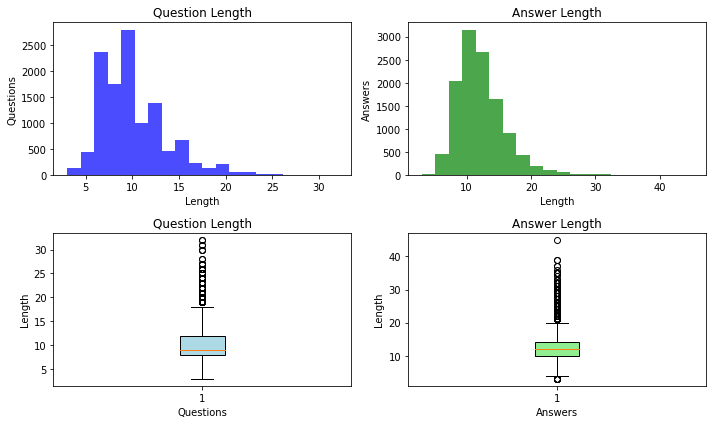

In [432]:
# 각 문장의 토큰 개수를 계산하는 함수
def calculate_sentence_length(sentences):
    return [len(sentence) for sentence in sentences]

# 질문과 답변의 길이 계산
question_lengths = calculate_sentence_length(questions_tokenized_a)
answer_lengths = calculate_sentence_length(answers_tokenized_a)

# 길이 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 질문 길이 분포 히스토그램
plt.subplot(2, 2, 1)
plt.hist(question_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Question Length')
plt.xlabel('Length')
plt.ylabel('Questions')

# 답변 길이 분포 히스토그램
plt.subplot(2, 2, 2)
plt.hist(answer_lengths, bins=20, color='green', alpha=0.7)
plt.title('Answer Length')
plt.xlabel('Length')
plt.ylabel('Answers')

# 질문 길이 박스플롯
plt.subplot(2, 2, 3)
plt.boxplot(question_lengths, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Question Length')
plt.xlabel('Questions')
plt.ylabel('Length')

# 답변 길이 박스플롯
plt.subplot(2, 2, 4)
plt.boxplot(answer_lengths, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Answer Length')
plt.xlabel('Answers')
plt.ylabel('Length')

plt.tight_layout()
plt.show()

In [433]:
# 패딩을 진행하고자 정의 -> 마스킹이 진행되므로 우선은 데이터의 가장 이상치인 30로 설정
MAX_LENGTH = 20

# Tokenize and filter 함수 구현
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + sp_tokenizer(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + sp_tokenizer(sentence2) + END_TOKEN

        # 길이를 MAX_LENGTH로 제한
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    return tokenized_inputs, tokenized_outputs

questions_a, answers_a = tokenize_and_filter(questions_a, answers_a)

print('단어장의 크기 :', (VOCAB_SIZE))
print('질문 데이터의 크기(shape) :', len(questions_a))
print('답변 데이터의 크기(shape) :', len(answers_a))

단어장의 크기 : 8002
질문 데이터의 크기(shape) : 11338
답변 데이터의 크기(shape) : 11338


In [435]:
BATCH_SIZE_A = 32
BUFFER_SIZE = 20000

from tensorflow.keras.preprocessing.sequence import pad_sequences

# KoBERT에서 문자열 토큰을 정수 ID로 변환하는 함수
def tokenize_to_ids(sentences, sp_tokenizer):
    tokenized_ids = []
    for sentence in sentences:
        # 문장을 정수 ID로 변환
        tokens = sp_tokenizer(sentence)
        tokenized_ids.append(tokens)
    return tokenized_ids

# 질문과 답변을 정수 ID로 변환
questions_tokenized_a = tokenize_to_ids(questions_a, sp_tokenizer)
answers_tokenized_a = tokenize_to_ids(answers_a, sp_tokenizer)

# 패딩을 적용하여 모든 문장의 길이를 동일하게 설정
questions_padded = pad_sequences(questions_tokenized_a, maxlen=MAX_LENGTH, padding='post')
answers_padded = pad_sequences(answers_tokenized_a, maxlen=MAX_LENGTH, padding='post')

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset_newtoken = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_padded,
        'dec_inputs': answers_padded[:, :-1]  # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers_padded[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset_newtoken = dataset_newtoken.cache()
dataset_newtoken = dataset_newtoken.shuffle(BUFFER_SIZE)
dataset_newtoken = dataset_newtoken.batch(BATCH_SIZE_A)
dataset_newtoken = dataset_newtoken.prefetch(tf.data.experimental.AUTOTUNE)

TypeError: not a string

## 해결 실패.. BERT 를 나중에 공부해야 해결할 수 있을 것 같다..

In [436]:
# 하이퍼 파라미터 조정을 통한 모델 정의

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4  # 인코더와 디코더의 층의 개수
D_MODEL = 256  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512  # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2  # 드롭아웃의 비율

# 모델 정의
model_newtoken = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model_newtoken.summary()


Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4156928     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [437]:
# 학습률과 옵티마이저를 정의하고 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model_newtoken.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [438]:
# 모델 학습
EPOCHS = 5

history = model_newtoken.fit(
    dataset_newtoken,
    epochs=EPOCHS
)

Epoch 1/5
369/369 [==============================] - 26s 43ms/step - loss: nan - accuracy: 0.6414
Epoch 2/5
369/369 [==============================] - 16s 43ms/step - loss: nan - accuracy: 0.6432
Epoch 3/5
369/369 [==============================] - 16s 44ms/step - loss: nan - accuracy: 0.6432
Epoch 4/5
369/369 [==============================] - 16s 43ms/step - loss: nan - accuracy: 0.6432
Epoch 5/5
369/369 [==============================] - 16s 45ms/step - loss: nan - accuracy: 0.6432


### Loss가 nan이 나오는 이유는 토큰화 진행 후 학습 과정에서 토큰나이저가 달라 학습과정에서의 오류가 났을 가능성이 높다고 판단한다.

In [439]:
# 트랜스포머 모델에 전처리가 진행된 사용자의 입력을 전달하여 단어 예측 수행
def evaluate_newtoken(sentence):
    # sp_tokenizer는 문장을 토큰화한 후 정수 리스트를 반환합니다.
    sentence_tokens = sp_tokenizer(sentence)

    # START_TOKEN과 END_TOKEN이 정수 리스트인지 확인
    sentence = tf.expand_dims(
        START_TOKEN + sentence_tokens + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model_newtoken(inputs=[sentence, output], training=False)

        # 예측 결과에서 마지막 단어 선택
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 예측한 단어가 종료 토큰이라면 예측을 중단합니다.
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어를 출력에 연결합니다.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [440]:
# 예측 수행한 결과를 출력하는 함수
def Q2(sentence):
    prediction = evaluate_newtoken(sentence)
    
    # 예측 결과를 디코딩해서 사람이 읽을 수 있는 문장으로 변환
    predicted_sentence = sp_tokenizer.DecodeIds(prediction.numpy().tolist())

    print('입력: {}'.format(sentence))
    print('출력: {}'.format(predicted_sentence))


In [441]:
# 예시 실행
Q2('저녁은 뭐 먹을까?')

ValueError: Can't convert Python sequence with mixed types to Tensor.

## 퍼실님게 문의해본 결과.. koBERT는 토큰화 과정이 다르므로 모델 구현 함수에 그대로 적용할 시 오류 가능성이 높다고 한다. 따로 처리해 주어야할 내용이 많아 BERT를 공부한 뒤 진행하는 것을 추천하셨다.. 근데 저는 CV 가고 싶어요...